## Libraries

In [2]:
from datasets import load_dataset

import pandas as pd
import numpy as np
import sklearn

import networkx as nx
from networkx.algorithms import bipartite

from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates 
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

## Initial Dataset Overview

In [4]:
# Check data types 
print("\nDataset information:")
print(df.info())

# Check missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# no duplicated rows
print("\nDuplicated Values:")
print("Duplicated values found" if any(df.duplicated()) else "No duplicated values found")
print()

# Check overall statistics
print(df.describe())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB
None

Missing Values:
No missing values found

Duplicated Values:
No duplicated values found

             cc_num           zip      city_pop      acct_num     unix_time  \
count  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  

## Data Preprocessing

In [5]:
df1 = df.copy()


In [6]:
# Convert date and time to appropriate data types
df1[['trans_date','dob']] = df1[['trans_date','dob']].apply(pd.to_datetime)
df1['trans_time'] = pd.to_datetime(df1['trans_time'], format='%H:%M:%S')

# Extract transaction time features
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df1['hour'] = df1['trans_time'].dt.hour
df1['day_of_week'] = pd.Categorical(df1['trans_date'].dt.day_name(), categories=week_order, ordered=True)
df1['month'] = df1['trans_date'].dt.to_period('M').dt.to_timestamp()
df1["trans_quarter"] = pd.PeriodIndex(df1['month'], freq='Q')
df1['year'] = df1['trans_date'].dt.year

# Calculate age at the time of the transaction
df1['age'] = (df1['trans_date'] - df1['dob']).dt.days / 365.25
df1['age_group'] = pd.cut(df1['age'], bins=range(0, 101, 10), right=False, 
                             labels=[f"{i}-{i+10}" for i in range(0, 100, 10)]) 

# Merge `first` and `last` columns
df1['full_name'] = df1['first'] + ' ' + df1['last']
df1 = df1.drop(['first', 'last'], axis=1) 

# Merge `city` and `state` columns
df1['city_state'] = df1['city'] + ', ' + df1['state']

# Clean `ssn` feature
df1['ssn']=df1['ssn'].str.replace('-','')
df1['ssn']=df1['ssn'].astype(int)

# Clean `merchant` feature
df1['merchant']=df1['merchant'].str.replace('fraud_','',regex=False)

In [7]:
# Dataset after preprocessing
# df1.info()

### Helper functions

In [8]:
# Helper functions
def fraud_filter(cols):
    return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def fraud_summary(df, col):
    print(f'Average fraud per {col}: {np.mean(df['fraud_count'])}')
    print(f'Median fraud per {col}: {np.median(df['fraud_count'])}')
    print(f'Standard deviation fraud per {col}: {np.std(df['fraud_count'])}')


## Data Exploration

In [9]:
# Check unique values in categorical columns
categorical = []

print('Unique values count')
for f in df1.columns:
    feature = df1[f]

    print(f'{f} unique values: {feature.nunique()}')
    if feature.dtype == float or feature.dtype == '<M8[ns]':
        print(' Not categorical')
        continue
    # If the number of unique features is less than half, more likely to be categorical
    if feature.nunique() < len(df1)/2:
        categorical.append(f)
        if feature.nunique() < 10:
            print(f'    Unique values: {feature.unique()}')
        continue
    print(' Not categorical')

Unique values count
ssn unique values: 997
cc_num unique values: 997
gender unique values: 2
    Unique values: ['F' 'M']
city unique values: 741
state unique values: 51
zip unique values: 942
city_pop unique values: 787
job unique values: 420
dob unique values: 978
 Not categorical
acct_num unique values: 997
trans_num unique values: 2646694
 Not categorical
trans_date unique values: 1095
 Not categorical
trans_time unique values: 86400
 Not categorical
unix_time unique values: 2573660
 Not categorical
category unique values: 14
amt unique values: 70272
 Not categorical
is_fraud unique values: 2
    Unique values: [1 0]
merchant unique values: 648
hour unique values: 24
day_of_week unique values: 7
    Unique values: ['Saturday', 'Sunday', 'Thursday', 'Wednesday', 'Friday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']
month unique values: 36
 Not categorical
trans_quarter unique values: 12
year unique

In [10]:
# Yearly transactions count: output looks evenly split
df1['year'].value_counts()

year
2023    884851
2022    882285
2021    879558
Name: count, dtype: int64

In [11]:
# Check if any `ssn` is linked to multiple credit card numbers
creditcard_count = df1.groupby('ssn')['cc_num'].apply(set).reset_index()
print(creditcard_count[creditcard_count['cc_num'].apply(lambda x: len(x)>1)]) # result: 1 ssn linked to only 1 cc_num

Empty DataFrame
Columns: [ssn, cc_num]
Index: []


## Fraudulent Label Analysis

#### Analysis Overview

In [12]:
# Summary statistics for fraudulent transactions
fraud_summarised = df1[df1['is_fraud'] == 1].describe()
print(fraud_summarised)

                ssn        cc_num           zip      city_pop  \
count  9.422000e+03  9.422000e+03   9422.000000  9.422000e+03   
mean   4.458670e+08  3.909210e+17  51318.872745  2.954356e+05   
min    1.280753e+06  6.040027e+10   1040.000000  1.410000e+02   
25%    2.064273e+08  3.897245e+13  27806.000000  1.718400e+04   
50%    4.653727e+08  3.506538e+15  48433.000000  5.922300e+04   
75%    6.642008e+08  4.506150e+15  77450.000000  2.398790e+05   
max    8.975991e+08  4.997335e+18  99701.000000  2.906700e+06   
std    2.595013e+08  1.265245e+18  29771.729243  5.808730e+05   

                                 dob      acct_num  \
count                           9422  9.422000e+03   
mean   1975-07-04 17:59:55.414986208  4.939769e+11   
min              1928-06-07 00:00:00  8.077997e+08   
25%              1961-09-07 00:00:00  2.443508e+11   
50%              1976-02-27 00:00:00  4.873495e+11   
75%              1992-04-08 00:00:00  7.486302e+11   
max              2008-10-14 00:00:00

**High imbalance in fraud and non-fraud counts**

Methods like SMOTE are needed to address imbalance

Fraud Distribution:
is_fraud
0    2637272
1       9422
Name: count, dtype: int64
Fraud Rate: 0.0036 (0.36%)


/var/folders/vx/dmx2bxqd2j59hsq717txvmgc0000gn/T/ipykernel_22476/1096215172.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='is_fraud', palette='Set2')


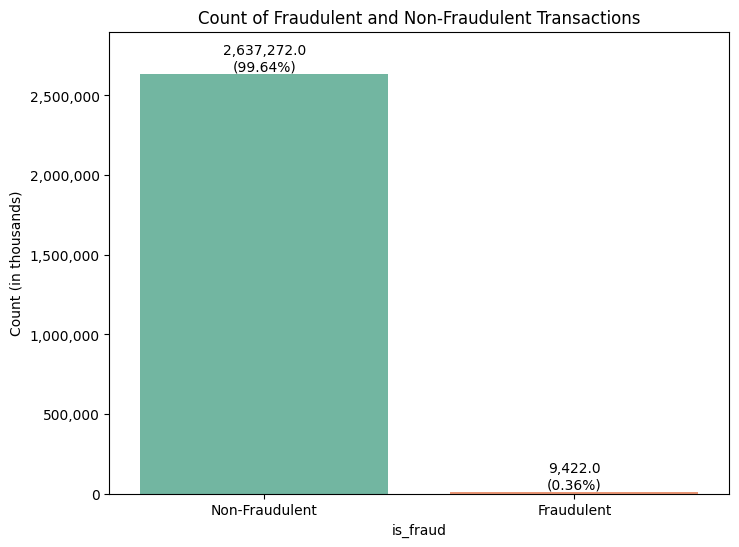

In [13]:
# Fraud distribution
print("Fraud Distribution:")
fraud_counts = df1['is_fraud'].value_counts()
print(fraud_counts)

# Fraud rate
fraud_rate = df1['is_fraud'].mean()
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate * 100:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='is_fraud', palette='Set2')

# Customize the plot
ax.set_ylabel('Count (in thousands)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Count of Fraudulent and Non-Fraudulent Transactions')
ax.set_xticks([0, 1])  # Set x-ticks
ax.set_xticklabels(['Non-Fraudulent', 'Fraudulent'])  # Label x-axis

# Extend y-axis limits slightly for readability
plt.ylim(0, max(fraud_counts) * 1.1)
# Add count and percentage on the bars
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        height + 1000,  # Y position (slightly above the bar)
        f'{height:,}\n({percentage:.2f}%)',  # Text (count and percentage)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

plt.show()

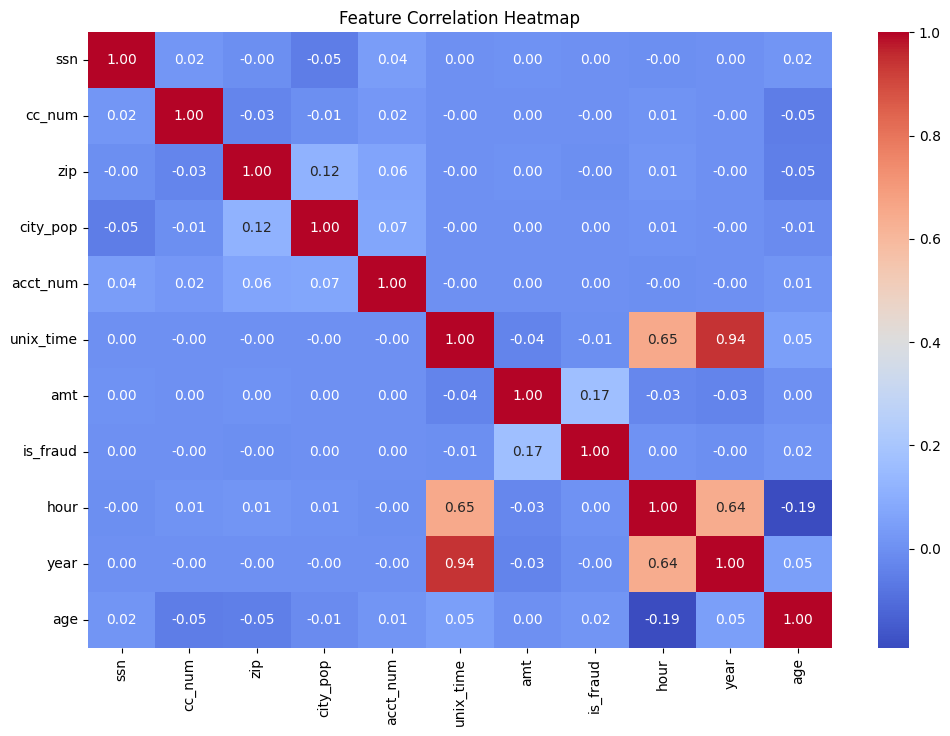

In [14]:
# Correlation heat map
df_numeric = df1.select_dtypes(include=['number'])

# Create the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [15]:
df_numeric.corr()

,ssn,cc_num,zip,city_pop,acct_num,unix_time,amt,is_fraud,hour,year,age
ssn,1.000000,0.017394,-0.003606,-0.054709,0.041788,0.000387,0.003156,0.000132,-0.003360,0.000544,0.016438
cc_num,0.017394,1.000000,-0.031622,-0.005406,0.024525,-0.000414,0.000638,-0.000562,0.011946,-0.000588,-0.054016
zip,-0.003606,-0.031622,1.000000,0.116971,0.063667,-0.001406,0.004174,-0.001987,0.014624,-0.001509,-0.052688
city_pop,-0.054709,-0.005406,0.116971,1.000000,0.069062,-0.001325,0.002613,0.001017,0.007053,-0.001336,-0.014805
acct_num,0.041788,0.024525,0.063667,0.069062,1.000000,-0.001354,0.002184,0.000362,-0.003023,-0.001706,0.014445
unix_time,0.000387,-0.000414,-0.001406,-0.001325,-0.001354,1.000000,-0.035291,-0.005659,0.651822,0.943567,0.049196
amt,0.003156,0.000638,0.004174,0.002613,0.002184,-0.035291,1.000000,0.169476,-0.028536,-0.034872,0.002204
is_fraud,0.000132,-0.000562,-0.001987,0.001017,0.000362,-0.005659,0.169476,1.000000,0.004777,-0.002710,0.015435
hour,-0.003360,0.011946,0.014624,0.007053,-0.003023,0.651822,-0.028536,0.004777,1.000000,0.644477,-0.193025
year,0.000544,-0.000588,-0.001509,-0.001336,-0.001706,0.943567,-0.034872,-0.002710,0.644477,1.000000,0.046799


### Fraudulent transactions by hour

In [16]:
# Get fraudulent transactions by hour
hour_fraud = df1.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0).reset_index(names=['hour', 0, 1])
hour_fraud.columns.name = None

#  Display the count of fraud by hour
print("Fraud Count by Hour:")
hour_fraud

Fraud Count by Hour:


,hour,0,1
0,0,83693,852
1,1,83202,855
2,2,83214,845
3,3,83660,872
4,4,83786,67
5,5,84056,59
6,6,83781,68
7,7,83892,62
8,8,83972,68
9,9,83696,59


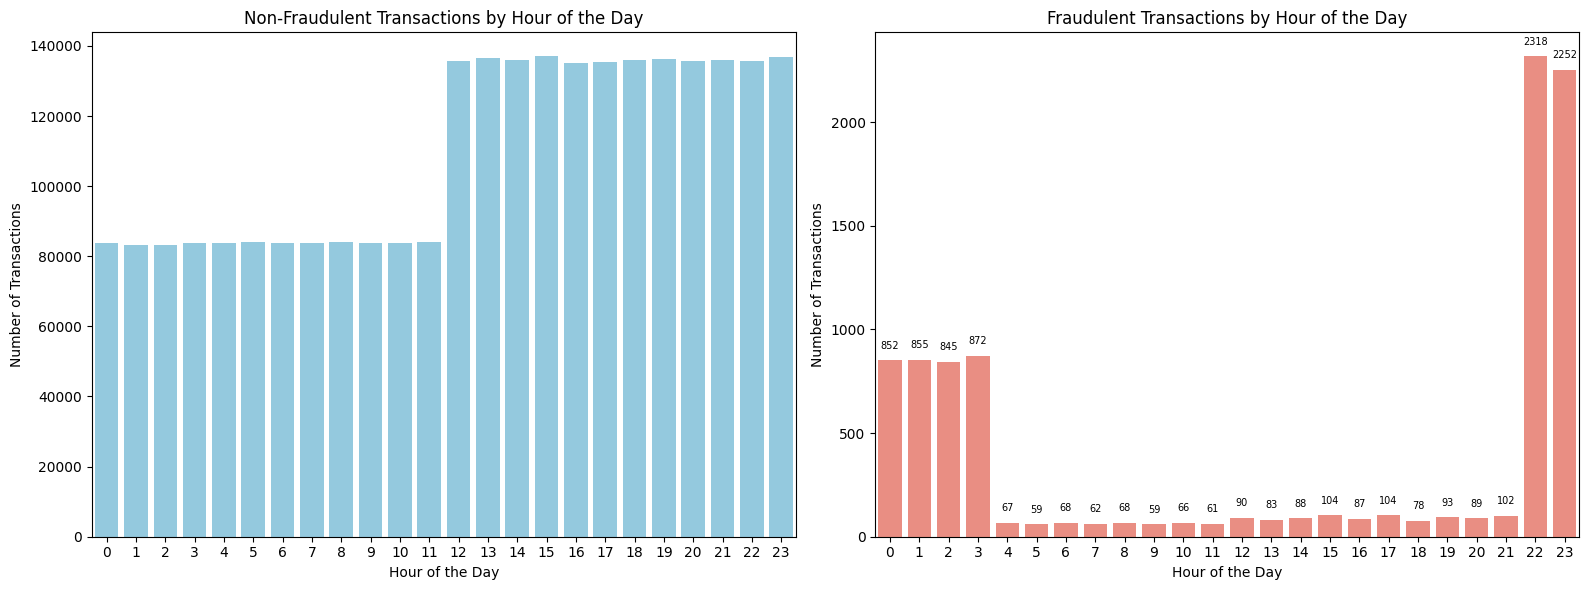

In [17]:
# Create subplots for hour analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Transactions')

# Add data point values: Too cramped and not as useful
'''for x, y in zip(hour_fraud['hour'], hour_fraud[0]):
    axes[0].text(x, y+max(hour_fraud[0])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=8)'''
    
# Plot Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Transactions')

# Add data point values
for x, y in zip(hour_fraud['hour'], hour_fraud[1]):
    axes[1].text(x, y+max(hour_fraud[1])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=7)
    

plt.tight_layout()
plt.show()

In [18]:
# Group by unix_time and count transactions
time_grouped = df1.groupby('unix_time').agg(
    num_transactions=('trans_num', 'size'),
    num_unique_cards=('cc_num', 'nunique'),
    num_unique_merchants=('merchant', 'nunique'),
    num_fraud=('is_fraud', 'sum'),
).reset_index()

# Filter for times with multiple transactions
suspicious_times = time_grouped[time_grouped['num_transactions'] > 1].sort_values(by='num_transactions', ascending=False)

# Display the top 10 suspicious times
print("Top 10 Suspicious unix_time with multiple transactions:")
print(suspicious_times.head(10))

# results show that despite sharing unix_time, most of these transactions seem to be all unique and independent,
# hence unlikely to be coordinated fraud. Could be due to peak shopping times or other reasons.  

Top 10 Suspicious unix_time with multiple transactions:
          unix_time  num_transactions  num_unique_cards  num_unique_merchants  \
2299353  1695553714                 5                 5                     5   
2556003  1703772009                 5                 5                     5   
829445   1640427909                 5                 5                     5   
558446   1631405689                 4                 4                     4   
2477650  1702115434                 4                 4                     3   
800651   1639826498                 4                 4                     4   
2477627  1702115269                 4                 4                     4   
471629   1628374273                 4                 4                     4   
1682405  1671815718                 4                 4                     4   
1693533  1671987473                 4                 4                     4   

         num_fraud  
2299353          0  
2556003   

### Fraudulent transactions by day of the week

/var/folders/vx/dmx2bxqd2j59hsq717txvmgc0000gn/T/ipykernel_22476/1456419947.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')


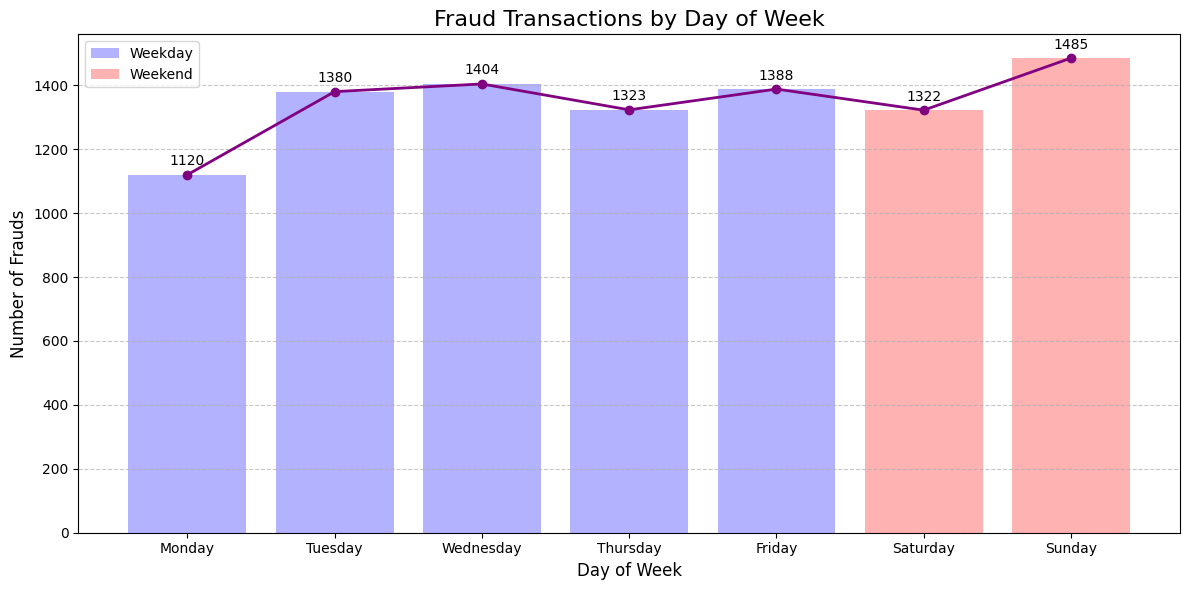

Total Weekday Frauds: 6615
Total Weekend Frauds: 2807
Weekday Average (per day): 1323.00
Weekend Average (per day): 1403.50


In [19]:
# Filter for fraud by day of week
fraud_daily_df = fraud_filter('day_of_week')
fraud_daily_df['Is_Weekend'] = [0, 0, 0, 0, 0, 1, 1] # 0 for weekday, 1 for weekend

# Plot fraud count by day of week
plt.figure(figsize=(12, 6))

# Set different colors for weekdays and weekends
colors = ['blue' if is_weekend == 0 else 'red' for is_weekend in fraud_daily_df['Is_Weekend']]

plt.plot(fraud_daily_df['day_of_week'], fraud_daily_df['fraud_count'], 
         marker='o', linestyle='-', color='purple', linewidth=2)

# Add bars with different colors for weekday/weekend
plt.bar(fraud_daily_df['day_of_week'], fraud_daily_df['fraud_count'], 
        alpha=0.3, color=colors)

# Add title and labels
plt.title("Fraud Transactions by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add legend
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Weekday'),
    Patch(facecolor='red', alpha=0.3, label='Weekend')
]
plt.legend(handles=legend_elements)

# Add value labels above each bar
for i, count in enumerate(fraud_daily_df['fraud_count']):
    plt.text(i, count + max(fraud_daily_df['fraud_count'])*0.02, f'{int(count)}', 
             ha='center', fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary of weekday vs weekend
weekday_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 0]['fraud_count'].sum()
weekend_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 1]['fraud_count'].sum()

print(f"Total Weekday Frauds: {int(weekday_fraud)}")
print(f"Total Weekend Frauds: {int(weekend_fraud)}")
print(f"Weekday Average (per day): {weekday_fraud/5:.2f}")
print(f"Weekend Average (per day): {weekend_fraud/2:.2f}")

### Fraudulent transactions by date

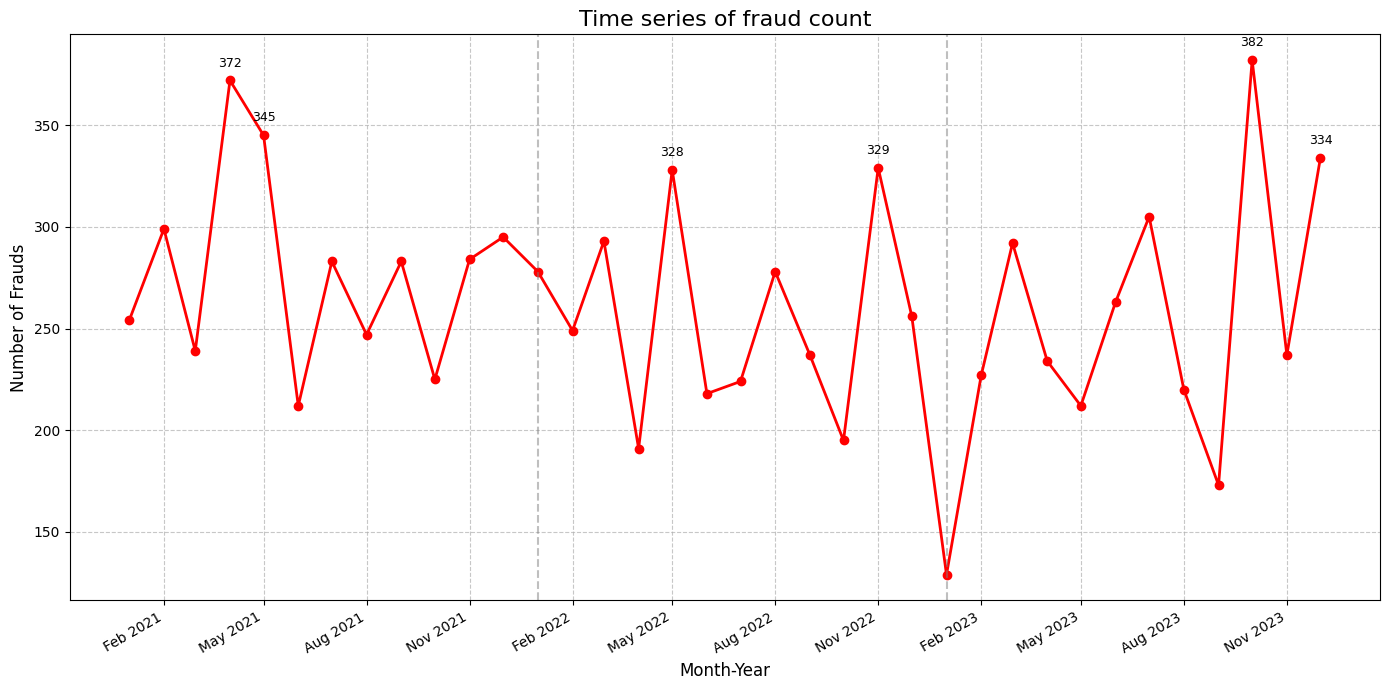

Total number of frauds: 9422
Month with most frauds: Oct 2023 (382 frauds)
Month with least frauds: Jan 2023 (129 frauds)


In [20]:
# Overview of fraud counts by month
fraud_count_df = df1[["month", "is_fraud"]].groupby(by = "month", as_index = False).sum().rename(columns={'month':'Date', 'is_fraud':'Fraud_Count'}).sort_values('Date')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(fraud_count_df['Date'], fraud_count_df['Fraud_Count'], 
         marker='o', linestyle='-', color='red', linewidth=2)

# Format x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add title and labels
plt.title("Time series of fraud count", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight year transitions with vertical lines
years = fraud_count_df['Date'].dt.year.unique()
for year in years[1:]:  # Skip the first year
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color='gray', linestyle='--', alpha=0.5)

# Add data annotations for peak points
peak_threshold = fraud_count_df['Fraud_Count'].max() * 0.8
peaks = fraud_count_df[fraud_count_df['Fraud_Count'] >= peak_threshold]
for i, row in peaks.iterrows():
    plt.annotate(f"{int(row['Fraud_Count'])}", 
                 (row['Date'], row['Fraud_Count']),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics using existing data
print(f"Total number of frauds: {fraud_count_df['Fraud_Count'].sum()}")
print(f"Month with most frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmax(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].max())} frauds)")
print(f"Month with least frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmin(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].min())} frauds)")


<Figure size 800x600 with 0 Axes>

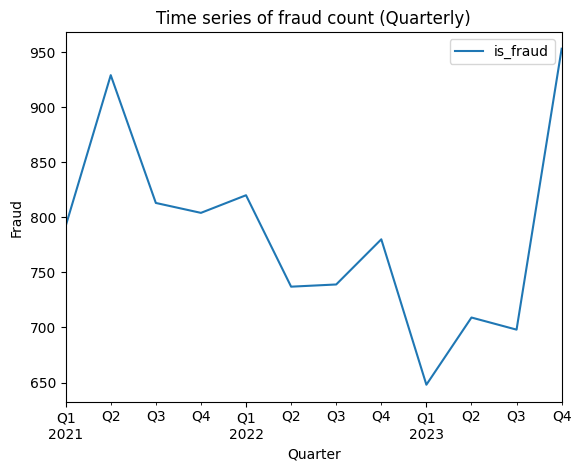

In [21]:
# Fraud counts on quarterly basis
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").sum()

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Time series of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

/var/folders/vx/dmx2bxqd2j59hsq717txvmgc0000gn/T/ipykernel_22476/723376522.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))


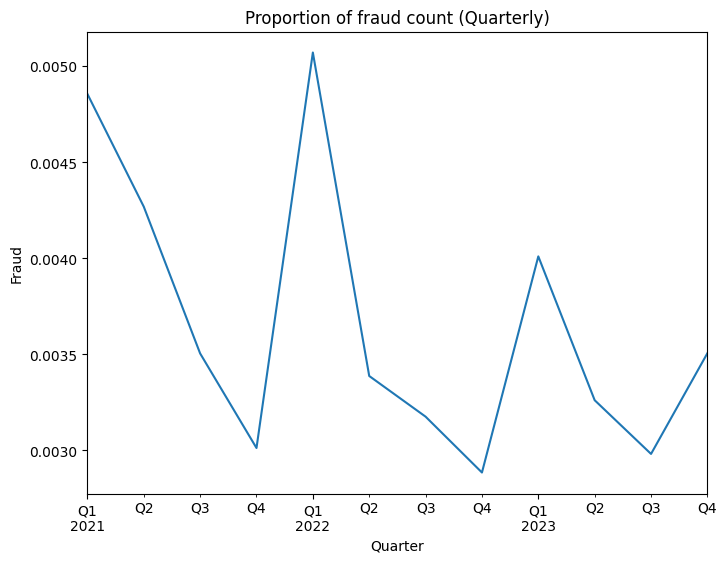

In [22]:
# Proportion of fraud (quarterly)
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Proportion of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

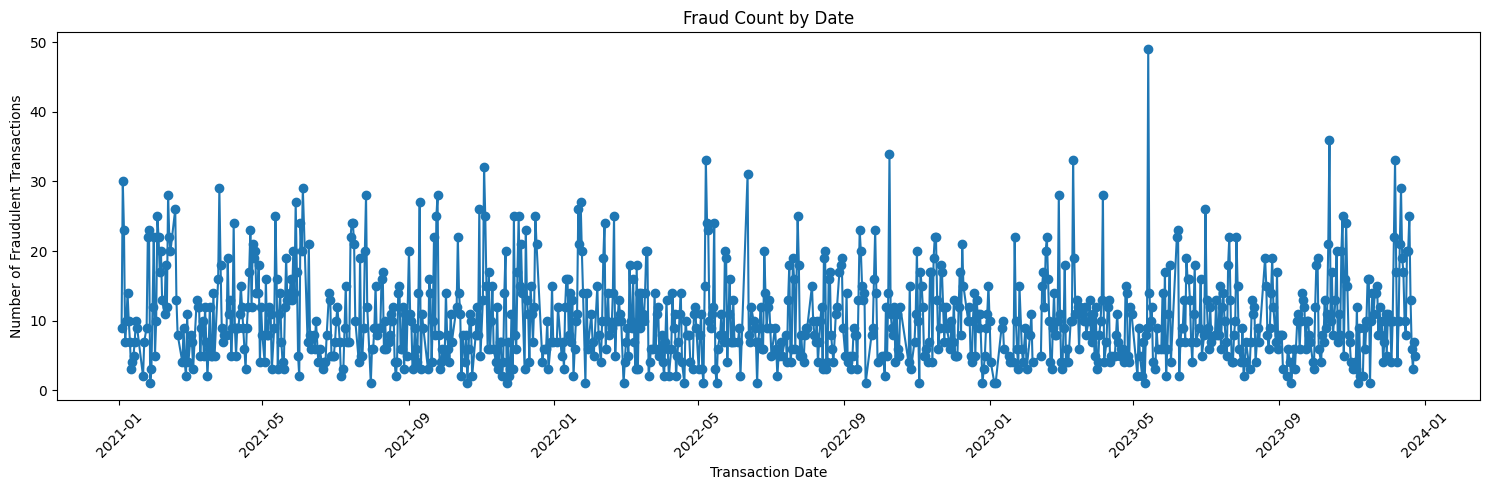

Dates with highest fraud:
    trans_date  fraud_count
713 2023-05-14           49
837 2023-10-13           36
540 2022-10-09           34
415 2022-05-08           33
889 2023-12-07           33
659 2023-03-12           33
255 2021-11-03           32
442 2022-06-12           31
1   2021-01-04           30
894 2023-12-12           29


In [23]:
# By date
fraud_count_by_date = fraud_filter('trans_date')

plt.figure(figsize=(15, 5))
plt.plot(fraud_count_by_date['trans_date'], fraud_count_by_date['fraud_count'], marker='o', linestyle='-')
plt.title('Fraud Count by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show dates with highest fraud
print("Dates with highest fraud:")
highest_fraud_dates = fraud_count_by_date.sort_values(by='fraud_count', ascending=False)
print(highest_fraud_dates.head(10))

**Unlikely that fraud is committed by duplicate transactions**

While there are non-negligible numbers of fraudulent transactions with duplicate time, there are relatively few cases associated with any customer or merchant.

In [24]:
# Check if there is fraud related to transaction time
unix_count = df1.groupby('unix_time')['unix_time'].count().reset_index(name='count').sort_values('count', ascending=False)
unix_count = unix_count[unix_count['count'] > 1]['unix_time']

duplicated_unix_time = df1[df1['unix_time'].isin(unix_count)].sort_values('unix_time')
duplicated_unix_time

,ssn,cc_num,gender,city,state,zip,city_pop,job,dob,acct_num,...,merchant,hour,day_of_week,month,trans_quarter,year,age,age_group,full_name,city_state
1058234,804928268,503871487271,F,Avon,CT,6001,18385,Music therapist,1988-06-17,308233949370,...,Cummings LLC,0,Friday,2021-01-01,2021Q1,2021,32.542094,30-40,Tina Olson,"Avon, CT"
2576115,24730528,4599996636186379,F,Dallas,TX,75252,1263321,Embryologist,2000-12-21,73869137112,...,Bins-Rice,0,Friday,2021-01-01,2021Q1,2021,20.030116,20-30,Ashley Hudson,"Dallas, TX"
389317,568920313,213164931214636,F,Wickes,AR,71973,1424,Engineer,1966-05-25,118531854265,...,Christiansen,0,Friday,2021-01-01,2021Q1,2021,54.606434,50-60,Leslie Evans,"Wickes, AR"
984222,158908788,5573585730652407,M,Gibsonia,PA,15044,27049,Designer,2000-12-06,580116407639,...,Raynor,0,Friday,2021-01-01,2021Q1,2021,20.071184,20-30,John Kim,"Gibsonia, PA"
86591,813386608,30391900889913,F,Marietta,GA,30062,302309,Engineer,1985-06-17,502226927571,...,Cummings LLC,0,Friday,2021-01-01,2021Q1,2021,35.542779,30-40,Barbara Wilson,"Marietta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268502,310243661,373711222990773,M,Fort Worth,TX,76103,813980,Health promotion specialist,1974-06-29,611759212133,...,Hodkiewicz,23,Sunday,2023-12-01,2023Q4,2023,49.505818,40-50,Jacob Hale,"Fort Worth, TX"
684163,869591502,4900532931839331,M,Dallas,TX,75252,1263321,Agricultural engineer,1988-02-27,13450992449,...,Kovacek Ltd,23,Sunday,2023-12-01,2023Q4,2023,35.841205,30-40,Gary Hernandez,"Dallas, TX"
414092,69452671,4029295014372,F,Massapequa,NY,11758,53804,Therapist,2006-08-29,100931152672,...,Fritsch LLC,23,Sunday,2023-12-01,2023Q4,2023,17.338809,10-20,Destiny Parrish,"Massapequa, NY"
13843,609849379,4489420466489667606,F,Oceanside,NY,11572,30574,Teacher,1993-11-03,860928862867,...,Boyer-Haley,23,Sunday,2023-12-01,2023Q4,2023,30.157426,30-40,Erin Graham,"Oceanside, NY"


In [25]:
# Identify merchants with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['merchant'])['merchant'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,merchant,count
150,Reichert,8
156,Romaguera,5
140,O'Keefe-Hudson,4
141,Pacocha-O'Reilly,4
21,Boyer PLC,4
45,Fisher-Schowalter,4
89,Jaskolski-Vandervort,3
71,Heller,3
95,Kerluke,3
173,Stamm-Witting,3


In [26]:
# Identify ssn with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['ssn'])['ssn'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,ssn,count
213,805105003,4
234,883641316,3
104,404227265,3
169,645243054,3
126,477507101,3
128,486855972,3
231,872212853,3
26,86372495,3
219,819995931,2
210,796451027,2


 ### Warm up and cool down periods (customers)

In [27]:
# Graph of warm up and cool down periods. Warm up period refer to no. of days between first normal transaction and first fradulent transactions.
# Cool down refers to no. of days between their very last fruadulent transaction and overall last transaction.
def calculate_periods(df):
    first_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    first_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    # Merge the DataFrames
    periods = pd.DataFrame(index=first_fraud.index)
    periods['first_trans_date'] = first_trans['trans_date']
    periods['last_trans_date'] = last_trans['trans_date']
    periods['first_fraud_date'] = first_fraud['trans_date']
    periods['last_fraud_date'] = last_fraud['trans_date']
    
    # Calculate periods in days
    periods['warmup_days'] = (periods['first_fraud_date'] - periods['first_trans_date']).dt.days
    periods['cooldown_days'] = (periods['last_trans_date'] - periods['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods['warmup_period_grp'] = periods['warmup_days'].apply(categorize_period)
    periods['cooldown_period_grp'] = periods['cooldown_days'].apply(categorize_period)
    
    return periods

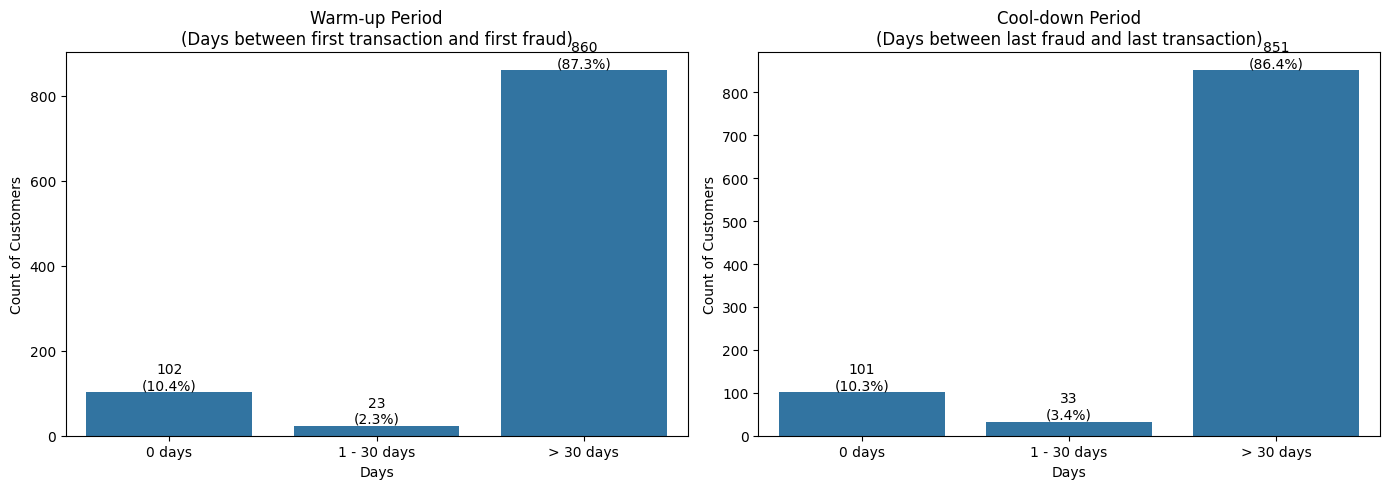

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days    102
1       1 - 30 days     23
2         > 30 days    860

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days    101
1         1 - 30 days     33
2           > 30 days    851

Percentage of customers whose first transaction was fraudulent:
10.4% (102 customers)

Percentage of customers whose last transaction was fraudulent:
10.3% (101 customers)


In [28]:
# Calculate periods
fraud_customer_periods = calculate_periods(df1)

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts = fraud_customer_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_customers = warmup_counts['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts = fraud_customer_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_customers = cooldown_counts['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts)

# Additional insights
print("\nPercentage of customers whose first transaction was fraudulent:")
first_fraud_pct = (fraud_customer_periods['warmup_days'] == 0).mean() * 100
print(f"{first_fraud_pct:.1f}% ({(fraud_customer_periods['warmup_days'] == 0).sum()} customers)")

print("\nPercentage of customers whose last transaction was fraudulent:")
last_fraud_pct = (fraud_customer_periods['cooldown_days'] == 0).mean() * 100
print(f"{last_fraud_pct:.1f}% ({(fraud_customer_periods['cooldown_days'] == 0).sum()} customers)")

 ### Warm up and cool down periods (merchants)

In [29]:
# Graph of warm up and cool down periods for merchants
def calculate_periods_merchants(df):
    first_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    first_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    # Merge the DataFrames
    periods_merchant = pd.DataFrame(index=first_fraud_merchant.index)
    periods_merchant['first_trans_date'] = first_trans_merchant['trans_date']
    periods_merchant['last_trans_date'] = last_trans_merchant['trans_date']
    periods_merchant['first_fraud_date'] = first_fraud_merchant['trans_date']
    periods_merchant['last_fraud_date'] = last_fraud_merchant['trans_date']
    
    # Calculate periods in days
    periods_merchant['warmup_days'] = (periods_merchant['first_fraud_date'] - periods_merchant['first_trans_date']).dt.days
    periods_merchant['cooldown_days'] = (periods_merchant['last_trans_date'] - periods_merchant['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods_merchant['warmup_period_grp'] = periods_merchant['warmup_days'].apply(categorize_period)
    periods_merchant['cooldown_period_grp'] = periods_merchant['cooldown_days'].apply(categorize_period)
    
    return periods_merchant

# Calculate periods
fraud_merchant_periods = calculate_periods_merchants(df1)

There are 648 unique merchants. 641 of them have been involved in fraud.


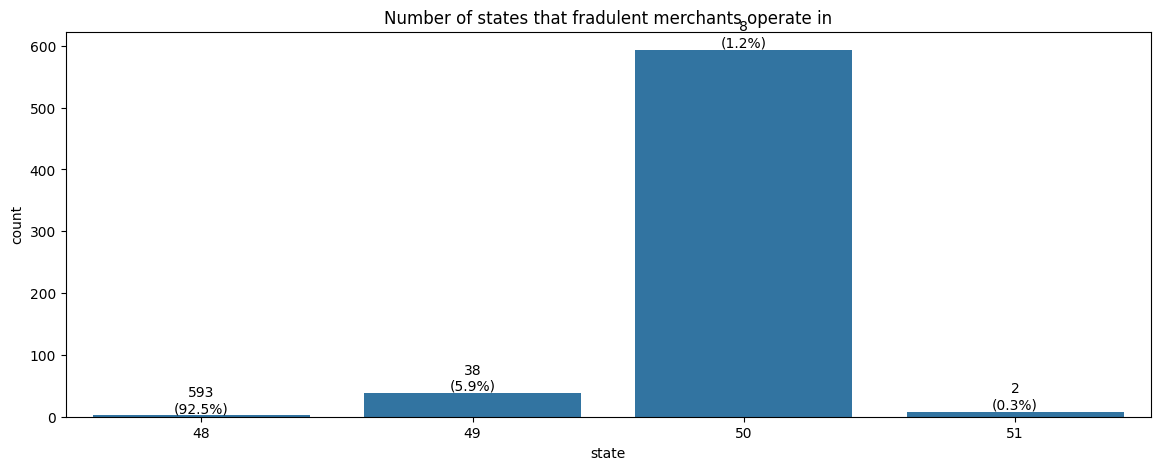

Most fradulent merchants operate in almost all states.


In [30]:
print(f"There are {len(df['merchant'].unique())} unique merchants. {len(fraud_merchant_periods)} of them have been involved in fraud.")

# Calculate number of states that fradulent merchants operates in
merchant_state = df1.loc[df1['merchant'].isin(fraud_merchant_periods.index)].groupby('merchant').nunique()['state'].reset_index()
# Tally state count
state_count = merchant_state['state'].value_counts().reset_index()

# Plot the bar plot
fig, ax = plt.subplots(figsize = (14,5))
sns.barplot(data = state_count, x = 'state', y = 'count', ax = ax)

total_merchants = state_count['count'].sum()
for i, p in enumerate(ax.patches):
    count = state_count.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    ax.annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    
ax.set_title('Number of states that fradulent merchants operate in')
plt.show()

# Print analysis
print('Most fradulent merchants operate in almost all states.')

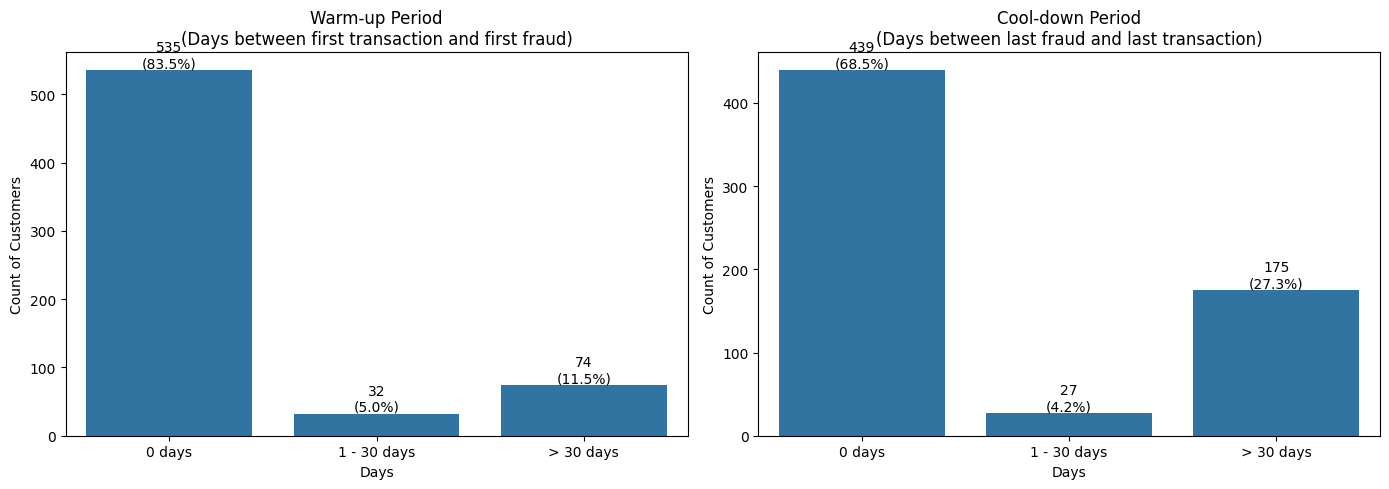

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days    535
1       1 - 30 days     32
2         > 30 days     74

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days    439
1         1 - 30 days     27
2           > 30 days    175

Percentage of merchants whose first transaction was fraudulent:
83.5% (535 merchants)

Percentage of merchants whose last transaction was fraudulent:
68.5% (439 merchants)


In [31]:

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts_merchant = fraud_merchant_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts_merchant.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts_merchant, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_merchants = warmup_counts_merchant['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts_merchant = fraud_merchant_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts_merchant.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts_merchant, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_merchants = cooldown_counts_merchant['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts_merchant)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts_merchant)

# Additional insights
print("\nPercentage of merchants whose first transaction was fraudulent:")
merchant_first_fraud_pct = (fraud_merchant_periods['warmup_days'] == 0).mean() * 100
print(f"{merchant_first_fraud_pct:.1f}% ({(fraud_merchant_periods['warmup_days'] == 0).sum()} merchants)")

print("\nPercentage of merchants whose last transaction was fraudulent:")
merchant_last_fraud_pct = (fraud_merchant_periods['cooldown_days'] == 0).mean() * 100
print(f"{merchant_last_fraud_pct:.1f}% ({(fraud_merchant_periods['cooldown_days'] == 0).sum()} merchants)")

It appears that fraudulent merchants are likely to immediately get involved in fraud and also stop transacting after the last fraud transaction.

This could lead to a hypothesis that some of these merchant accounts were created by fraudsters solely for the purpose of pulling off these frauds.

### Fraudulent transactions by location

/var/folders/vx/dmx2bxqd2j59hsq717txvmgc0000gn/T/ipykernel_22476/850821166.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary['state'], fontsize=8)


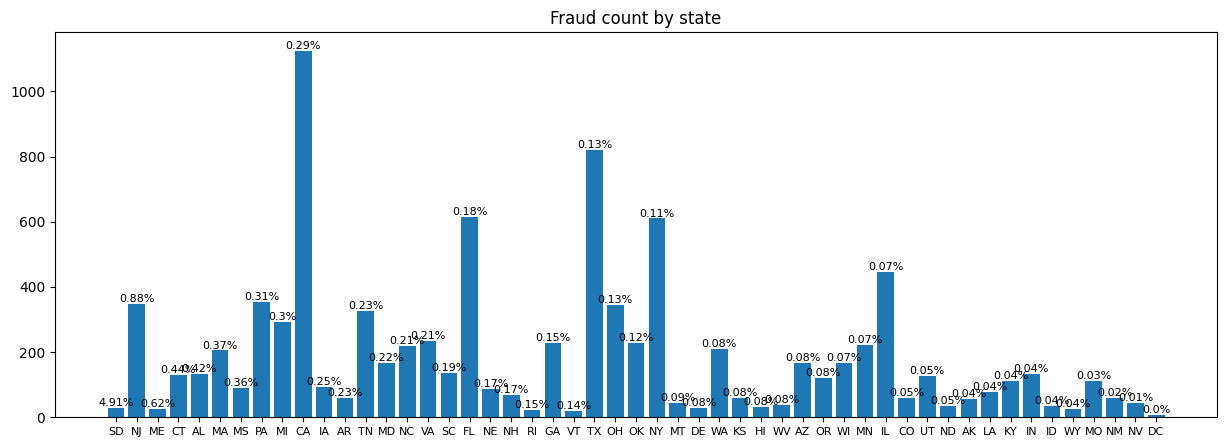

In [32]:
# Total and proportion of fraud by state
fraud_count_by_state = fraud_filter('state')
pop = df1.groupby('state')['city_pop'].mean().reset_index(name='mean_pop')

summary = fraud_count_by_state.merge(pop, on='state')
summary['percentage'] = round(summary['fraud_count']/summary['mean_pop']*100, 2)
summary = summary.sort_values(by='percentage', ascending=False)

fig, ax = plt.subplots(figsize=(15,5))

ax.bar(summary['state'], summary['fraud_count'])
ax.set_title('Fraud count by state')
ax.set_xticklabels(summary['state'], fontsize=8)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{summary["percentage"].iloc[i]}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=8)

plt.show()

**Higher population leads to higher number of fraud cases**

May be because it is easier to commit fraud in a large city.

From the data, it shows that cities with a larger population leads to greater number of frauds from the best fit line.

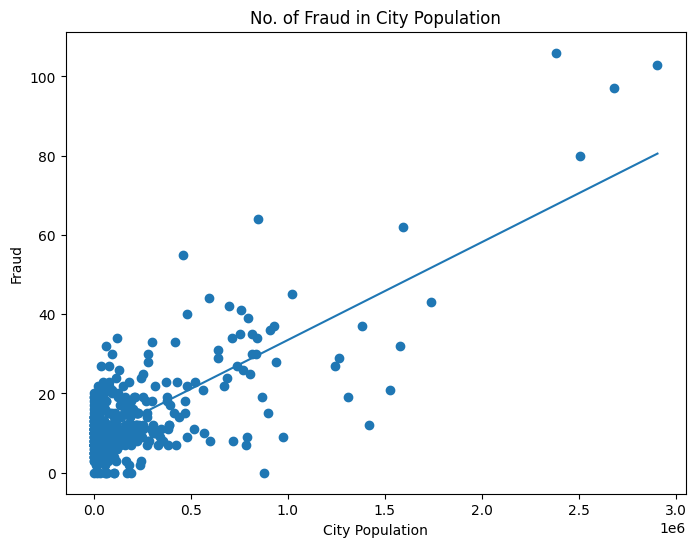

In [33]:
# Fraud count per city_pop. 
# Check if higher population leads to higher fraud cases
fraud_count = df1.groupby('city_pop')['is_fraud'].sum().reset_index()

a, b = np.polyfit(fraud_count["city_pop"], fraud_count["is_fraud"], 1)

plt.figure(figsize=(8, 6))
plt.scatter('city_pop','is_fraud', data=fraud_count)
plt.plot(fraud_count["city_pop"], a * fraud_count["city_pop"] + b)
plt.title('No. of Fraud in City Population')
plt.xlabel('City Population')
plt.ylabel('Fraud')
plt.show()

**Some cities are more popular for committing fraud**

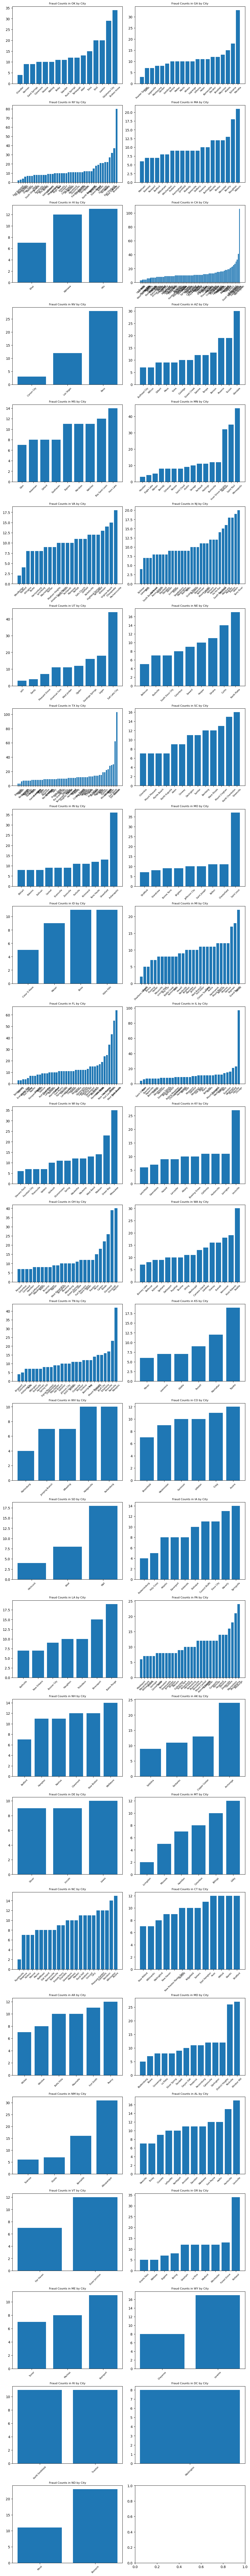

In [34]:
# Fraud count per city per state
fraud_count_by_city = fraud_filter(['state', 'city'])

states = list(df1['state'].unique())
n = len(states)

fig, ax = plt.subplots(n//2+1, 2, figsize=(10, 4*(n//2+1)), constrained_layout=True)

ax = ax.flatten()
for i, state in enumerate(states):
    temp = fraud_count_by_city[fraud_count_by_city['state'] == state].sort_values(by='fraud_count')

    ax[i].bar(temp['city'], temp['fraud_count'])
    ax[i].set_title(f'Fraud Counts in {state} by City', fontsize=8)
    ax[i].tick_params(axis='x', rotation=45, labelsize=6)

plt.show()

In [35]:
# City-level analysis across states
fraud_count_by_city = fraud_filter(['state', 'city'])
fraud_summary(fraud_count_by_city, 'city')

# Show highest fraud cities
print("\nCities with highest fraud counts:")
highest_fraud_loc = fraud_count_by_city[fraud_count_by_city['fraud_count'] > 12].sort_values(by='fraud_count', ascending=False)
print(highest_fraud_loc.head(10))

Average fraud per city: 12.094993581514762
Median fraud per city: 10.0
Standard deviation fraud per city: 9.152044075009778

Cities with highest fraud counts:
    state             city  fraud_count
70     CA      Los Angeles          106
680    TX          Houston          103
229    IL          Chicago           97
481    NY         Brooklyn           80
156    FL     Jacksonville           64
701    TX      San Antonio           62
183    FL  West Palm Beach           55
368    MN      Minneapolis           45
714    UT   Salt Lake City           44
163    FL            Miami           43


### Fraudulent transactions by category

In [36]:
# Fraud count and percentage per category
fraud_counts = df1[df1['is_fraud'] == 1]['category'].value_counts()
total_counts = df1['category'].value_counts()
fraud_percentage = (fraud_counts / total_counts * 100).fillna(0)

# As dataframe
fraud_by_cat = pd.DataFrame({'Fraud Cases': fraud_counts, 'Fraud Percentage': fraud_percentage})
fraud_by_cat = fraud_by_cat.sort_values(by='Fraud Cases', ascending=False)

print("Fraud cases and percentage by category:")
print(fraud_by_cat)

Fraud cases and percentage by category:
                Fraud Cases  Fraud Percentage
category                                     
shopping_net           2251          1.154531
grocery_pos            2205          0.892550
misc_net               1201          0.993852
shopping_pos           1097          0.421529
gas_transport           703          0.306866
entertainment           302          0.156057
misc_pos                290          0.166678
personal_care           261          0.139757
kids_pets               236          0.102737
home                    212          0.085584
food_dining             209          0.104848
health_fitness          163          0.098728
grocery_net             157          0.137750
travel                  135          0.159936


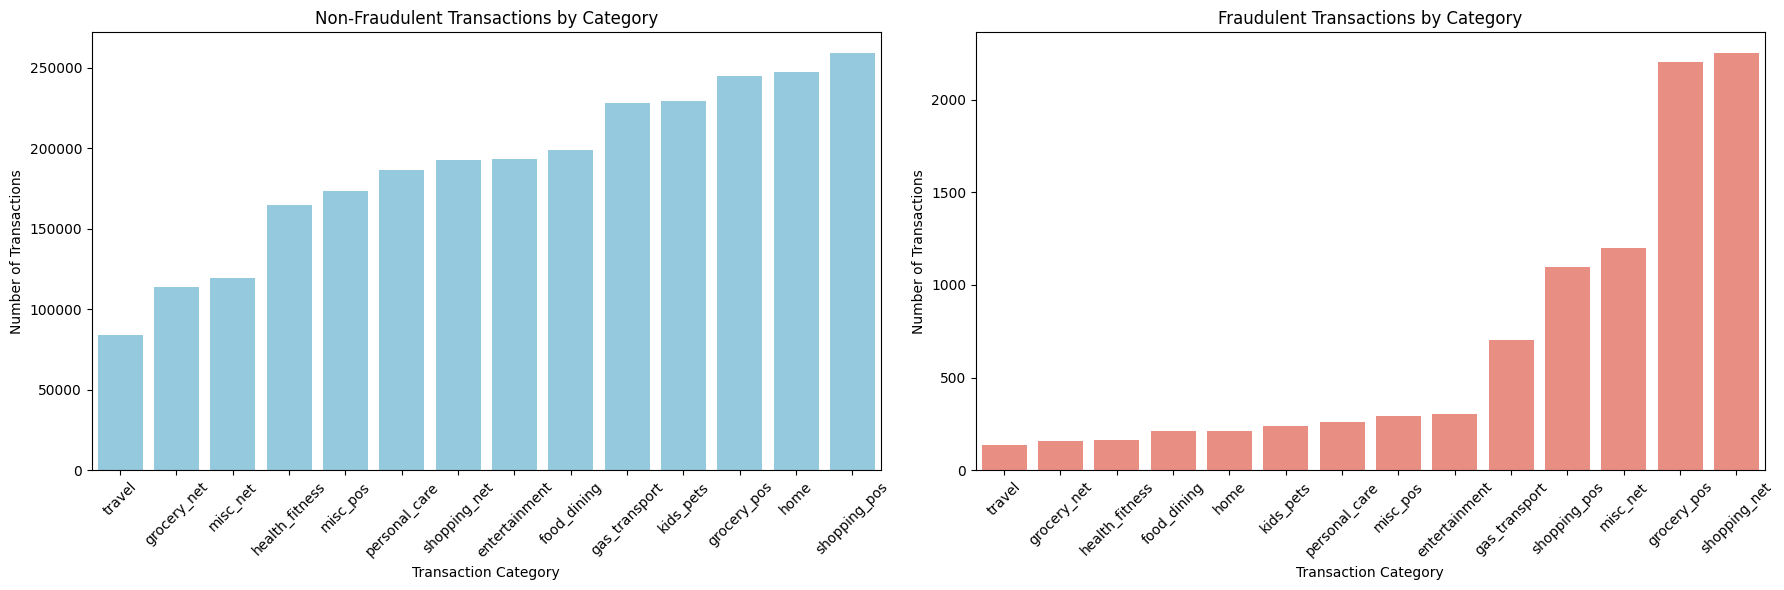

In [37]:
category_fraud = df1.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Non-Fraudulent Transactions by category
non_fraud = category_fraud.sort_values(by=0)
sns.barplot(x=non_fraud.index, y=non_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Category')
axes[0].set_xlabel('Transaction Category')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Plot Fraudulent Transactions by category
fraud = category_fraud.sort_values(by=1)
sns.barplot(x=fraud.index, y=fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Category')
axes[1].set_xlabel('Transaction Category')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Fraudulent transactions by age group

/var/folders/vx/dmx2bxqd2j59hsq717txvmgc0000gn/T/ipykernel_22476/2943096036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)


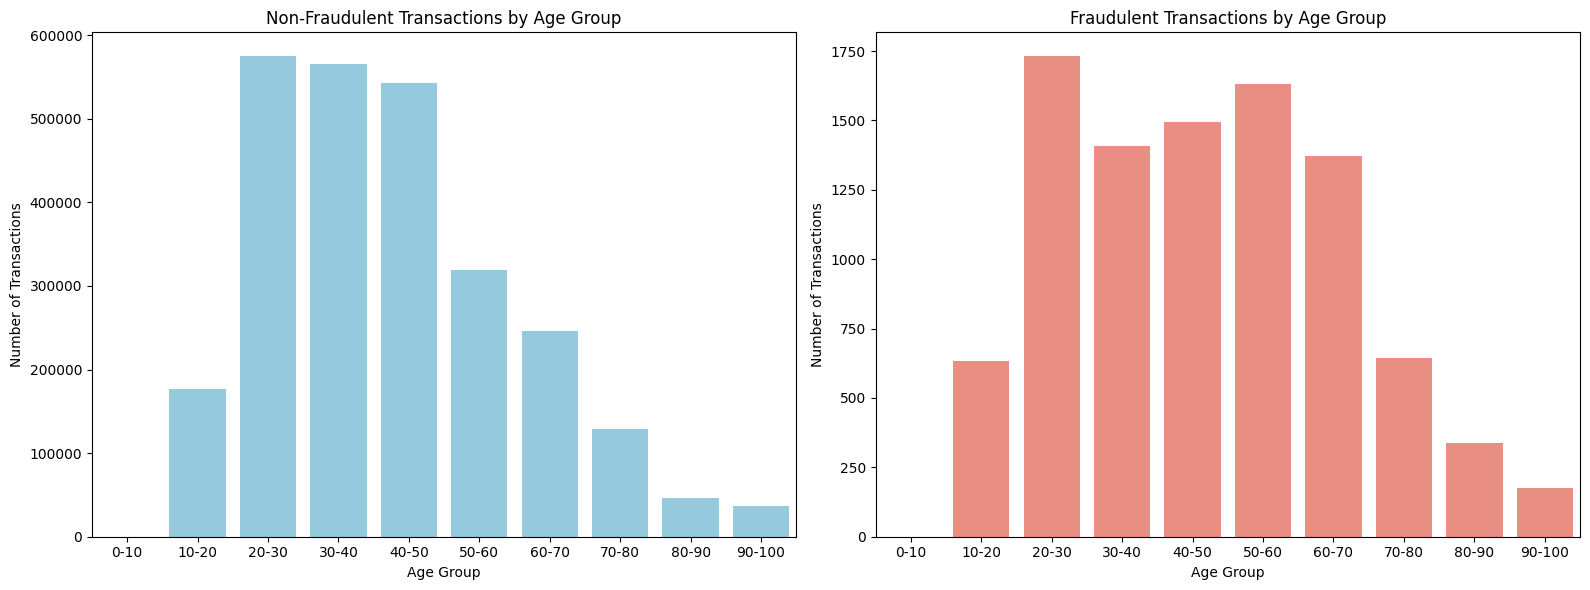

In [38]:
# Age analysis
age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for age analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Transactions')

# Plot Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

### Fraudulent transaction by occupation

**Some occupations are prone to greater risk of fraudulent transactions than others**

Occupations that have a tendency to have strong earning power shows greater proportion of transactions being fraudulent, showing a tendency for fraudsters to target individuals with wealth

                         job  is_fraud  total_count  fraud_percentage
0         Academic librarian        10         1104          0.905797
1      Accommodation manager        11         4381          0.251084
2                 Accountant       109        23052          0.472844
3      Accounting technician        40        10957          0.365063
4                      Actor        46        13156          0.349650
..                       ...       ...          ...               ...
415           Water engineer        18         4381          0.410865
416  Water quality scientist        11         2197          0.500683
417       Wellsite geologist         8         6556          0.122026
418                   Writer        16         4382          0.365130
419             Youth worker        53        20811          0.254673

[420 rows x 4 columns]


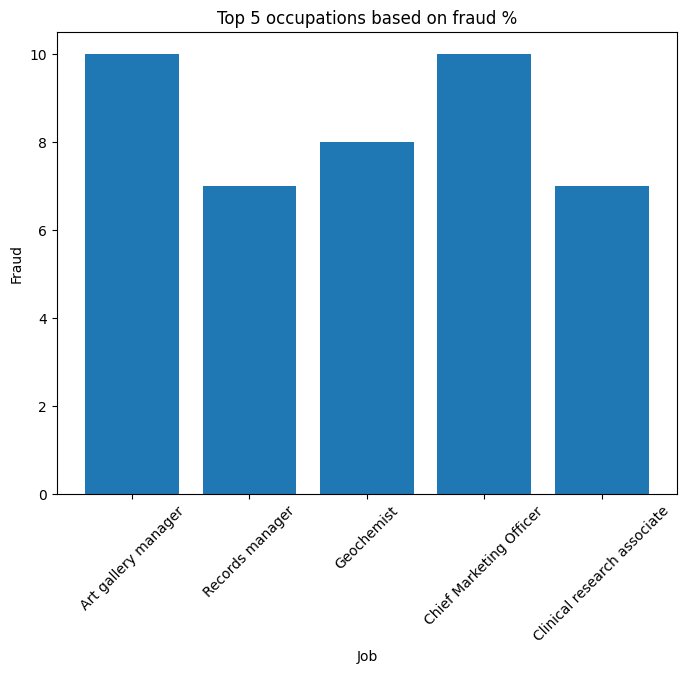

In [39]:
# x: city_state, y: fraud_count
# fraud count per city_pop, filter to a state to check
fraud_count = df1.groupby('job')['is_fraud'].sum().reset_index()

# Calculate total transactions by job
total_count = df1.groupby('job')['is_fraud'].count().reset_index()
total_count.rename(columns={'is_fraud': 'total_count'}, inplace=True)

# Merge fraud count and total count
fraud_percentage = pd.merge(fraud_count, total_count, on='job')

# Calculate percentage of fraud
fraud_percentage['fraud_percentage'] = (fraud_percentage['is_fraud'] / fraud_percentage['total_count']) * 100
top_5=fraud_percentage.sort_values(by='fraud_percentage',ascending=False).head(5)
print(fraud_percentage)
# show occupations with the highest % of frauds

plt.figure(figsize=(8, 6))
plt.bar('job','is_fraud', data=top_5) 
plt.title('Top 5 occupations based on fraud %')
plt.xlabel('Job')
plt.ylabel('Fraud')
plt.xticks(rotation=45)
plt.show()

### Fraudulent transactions by merchant


Merchants with highest fraud counts:
            merchant  fraud_count
472         Reichert          152
416         Mosciski           94
28          Baumbach           93
561          Streich           63
492        Romaguera           60
254             Huel           57
197        Greenholt           56
25   Bashirian Group           55
316          Kovacek           55
18      Bailey-Morar           55
Average fraud per merchant: 14.698907956318253
Median fraud per merchant: 7.0
Standard deviation fraud per merchant: 16.620424686155232


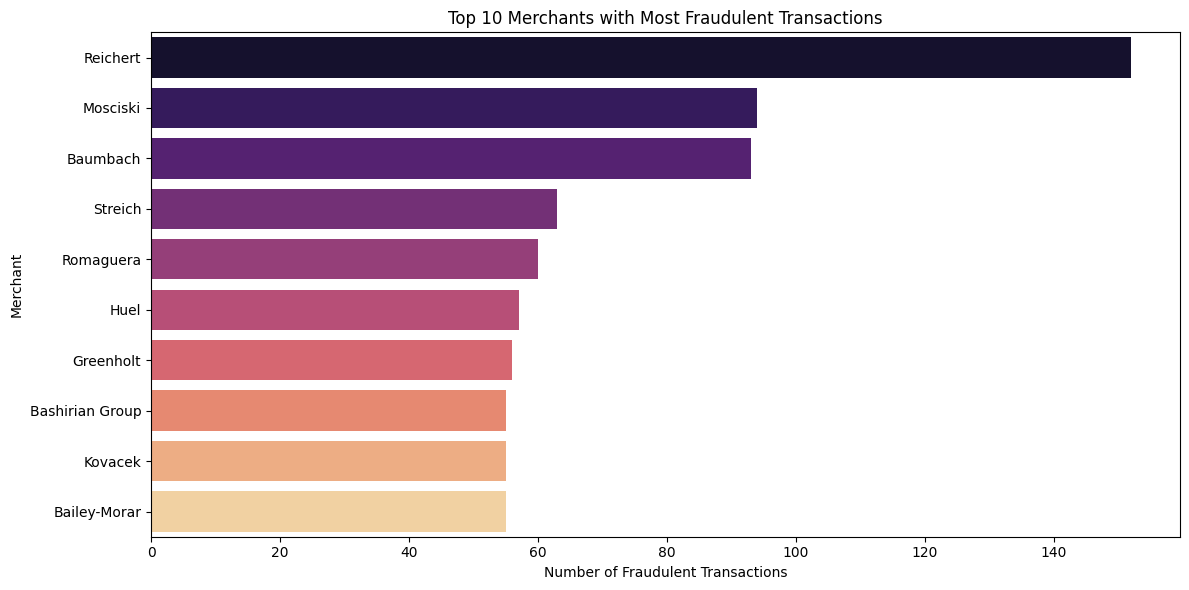


Analysis of top fraud merchants:
Merchant: Reichert
    Number of fraud transactions: 152
    Number of unique locations: 727
    Number of total customers: 11826
    Number of unique customers: 904
    Number of unique customers in fraud transactions: 140
    Average transaction amount: $75.36
    Most common transaction category: shopping_net
Merchant: Mosciski
    Number of fraud transactions: 94
    Number of unique locations: 726
    Number of total customers: 8780
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $78.40
    Most common transaction category: grocery_pos
Merchant: Baumbach
    Number of fraud transactions: 93
    Number of unique locations: 724
    Number of total customers: 14092
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $69.34
    Most common transaction category: shopping_pos


In [40]:
# Top merchants with fraudulent transactions
fraud_count_by_merchant = fraud_filter('merchant').sort_values(by='fraud_count', ascending=False)
print("Merchants with highest fraud counts:")
print(fraud_count_by_merchant.head(10))

# Calculate fraud summary stats for merchants
fraud_summary(fraud_count_by_merchant, 'merchant')

# Visualize top 10 merchants with most fraudulent transactions
top_fraud_merchants = fraud_count_by_merchant.nlargest(10, 'fraud_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_count', y='merchant', data=top_fraud_merchants, hue='merchant',palette='magma')
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

# Detailed analysis of top fraud merchants
print("\nAnalysis of top fraud merchants:")
fraud_merchants = list(fraud_count_by_merchant['merchant'].head(3))
for m in fraud_merchants:
    temp = df1[df1['merchant'] == m]
    print(f'Merchant: {m}')
    print(f'    Number of fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].count()}')
    print(f'    Number of unique locations: {temp["city_state"].nunique()}')
    print(f'    Number of total customers: {temp["ssn"].count()}')
    print(f'    Number of unique customers: {temp["ssn"].nunique()}')
    print(f'    Number of unique customers in fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].nunique()}')
    avg_transaction_amount = temp['amt'].mean()
    print(f'    Average transaction amount: ${avg_transaction_amount:.2f}')
    most_common_category = temp['category'].mode()[0]  # take the first value
    print(f'    Most common transaction category: {most_common_category}')

In [41]:
least_fraud_m = fraud_count_by_merchant.sort_values(by='fraud_count', ascending=True)
least_fraud_m.head(10)

,merchant,fraud_count
504,Runte,1
583,Trantow PLC,1
49,Bins-Howell,1
454,Pouros,1
630,Wuckert-Walter,1
33,Bednar Inc,1
473,Reichert-Weissnat,1
493,Romaguera Ltd,1
508,Satterfield-Lowe,1
17,Bahringer-Streich,1


In [42]:
least_fraud_filter = least_fraud_m[least_fraud_m['fraud_count'] == 1]['merchant']

fraud_count_mc = fraud_filter(['merchant', 'ssn'])
fraud_count_mc = fraud_count_mc[fraud_count_mc['merchant'].isin(least_fraud_filter)]
fraud_count_mc.head()

,merchant,ssn,fraud_count
253,Bahringer-Streich,504142358,1
655,Bednar Inc,649608105,1
813,Bins-Howell,437446587,1
1034,Boyer-Haley,96658934,1
1670,Deckow-Dare,589058010,1


### Fraudulent transactions by customers

In [43]:
# No. of unique customers based on ssn numbers (check why full names vs ssn/cc_num is different)
unique_customers = df1['ssn'].nunique()
print(f"Number of unique customers based on ssn: {unique_customers}")

fraud_customers_ssn = df1[df1['is_fraud'] == 1]['ssn'].nunique()
total_customers_ssn = df1['ssn'].nunique()

print(f"\nNumber of unique customers who committed fraud (based on SSN): {fraud_customers_ssn}")
print(f"Percentage of customers who committed fraud (based on SSN): {(fraud_customers_ssn/total_customers_ssn)*100:.2f}%")


Number of unique customers based on ssn: 997

Number of unique customers who committed fraud (based on SSN): 985
Percentage of customers who committed fraud (based on SSN): 98.80%


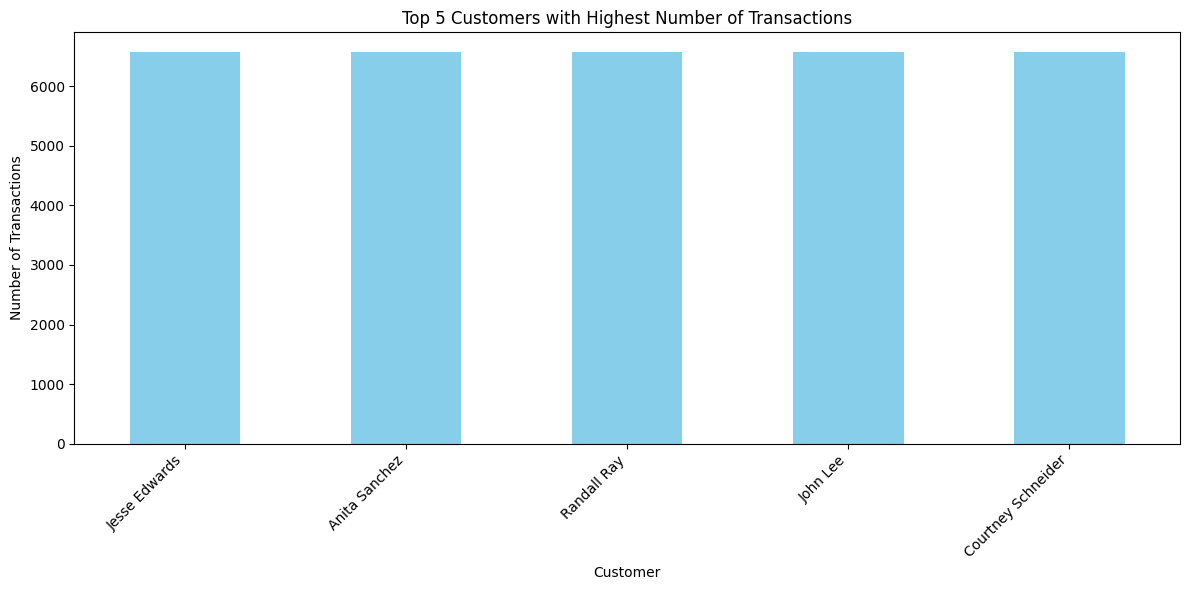

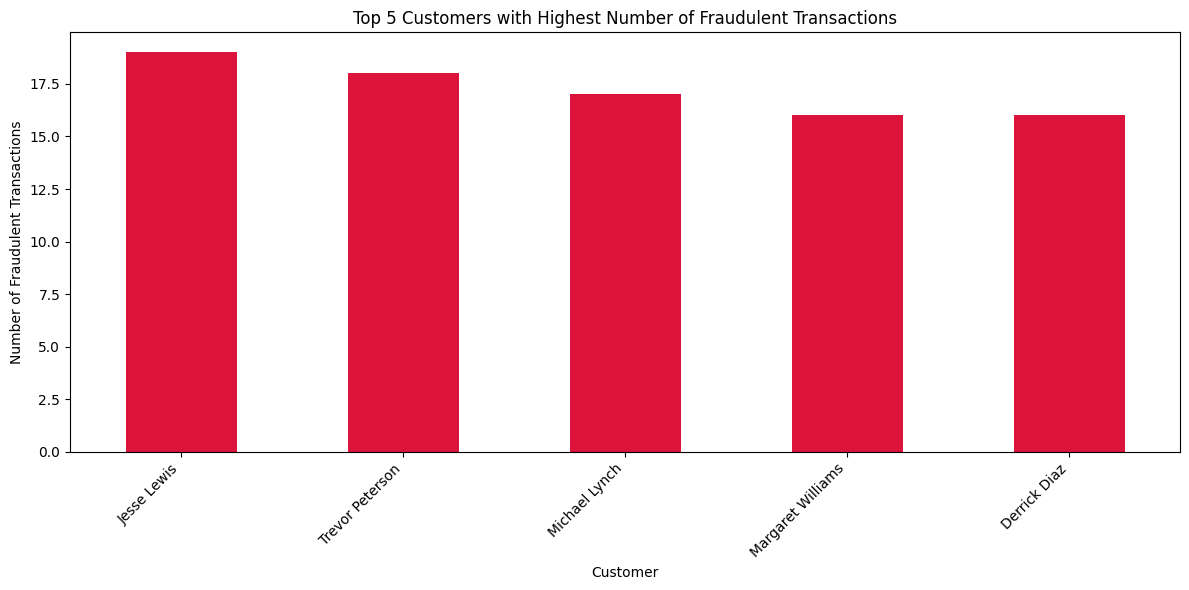

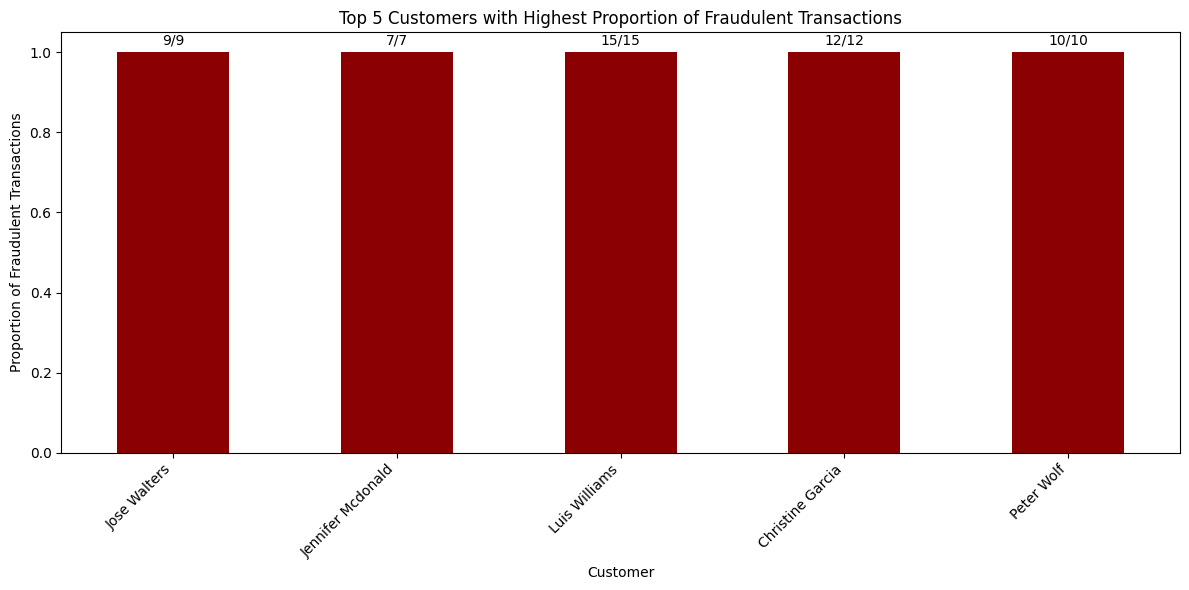

In [ ]:
# To make more sense, even though we use ssn to identify top customers, we will display their full names on the graph for better identification
ssn_to_name = df1[['ssn', 'full_name']].drop_duplicates('ssn').set_index('ssn')['full_name']

# 1. Bar plot of top 5 customers with highest number of transactions
top_customers_by_trans_count = df1.groupby('ssn').size().sort_values(ascending=False).head(5)
top_customer_names = [ssn_to_name[ssn] for ssn in top_customers_by_trans_count.index]

plt.figure(figsize=(12, 6))
ax1 = top_customers_by_trans_count.plot(kind='bar', color='skyblue')
plt.title('Top 5 Customers with Highest Number of Transactions')
plt.xlabel('Customer')
plt.ylabel('Number of Transactions')
ax1.set_xticklabels(top_customer_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Bar plot of top 5 customers with highest number of fraudulent transactions
fraud_counts = df1[df1['is_fraud'] == 1].groupby('ssn').size().sort_values(ascending=False).head(5)
fraud_customer_names = [ssn_to_name[ssn] for ssn in fraud_counts.index]

plt.figure(figsize=(12, 6))
ax2 = fraud_counts.plot(kind='bar', color='crimson')
plt.title('Top 5 Customers with Highest Number of Fraudulent Transactions')
plt.xlabel('Customer')
plt.ylabel('Number of Fraudulent Transactions')
ax2.set_xticklabels(fraud_customer_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Top 5 customers with highest proportion of fraudulent transactions
# Total transactions per customer
total_trans_per_customer = df1.groupby('ssn').size()

# No. of fraudulent transactions per customer
fraud_trans_per_customer = df1[df1['is_fraud'] == 1].groupby('ssn').size()

# Calculate proportion of fraudulent transactions
fraud_proportion = pd.DataFrame({
    'total_transactions': total_trans_per_customer,
    'fraud_transactions': fraud_trans_per_customer
}).fillna(0)

fraud_proportion['fraud_ratio'] = fraud_proportion['fraud_transactions'] / fraud_proportion['total_transactions']

# Get top 5 customers with highest fraud ratio (with at least 1 fraud transaction)
top_fraud_ratio = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].sort_values(
    'fraud_ratio', ascending=False).head(5)

fraud_ratio_names = [ssn_to_name[ssn] for ssn in top_fraud_ratio.index]

plt.figure(figsize=(12, 6))
ax3 = top_fraud_ratio['fraud_ratio'].plot(kind='bar', color='darkred')
plt.title('Top 5 customers with Highest Ratio of Fraud:Non-Fraud Transactions')
plt.xlabel('Customer')
plt.ylabel('Proportion of Fraudulent Transactions')
ax3.set_xticklabels(fraud_ratio_names, rotation=45, ha='right')

# Add transaction counts as text on each bar
for i, (idx, row) in enumerate(top_fraud_ratio.iterrows()):
    plt.text(i, row['fraud_ratio'] + 0.02, 
             f"{int(row['fraud_transactions'])}/{int(row['total_transactions'])}", 
             ha='center')

plt.tight_layout()
plt.show()

In [45]:
# Print the actual numbers for reference
print("Top 5 customers with highest number of transactions:")
for ssn, count in zip(top_customers_by_trans_count.index, top_customers_by_trans_count.values):
    print(f"{ssn_to_name[ssn]}: {count} transactions")

print("\nTop 5 customers with highest number of fraudulent transactions:")
for ssn, count in zip(fraud_counts.index, fraud_counts.values):
    print(f"{ssn_to_name[ssn]}: {count} fraudulent transactions")

print("\nTop 5 customers with highest ratio of fraud:non-fraud transactions:")
for ssn, row in top_fraud_ratio.iterrows():
    print(f"{ssn_to_name[ssn]}: {row['fraud_ratio']:.2%} ({int(row['fraud_transactions'])}/{int(row['total_transactions'])})")

Top 5 customers with highest number of transactions:
Jesse Edwards: 6578 transactions
Anita Sanchez: 6575 transactions
Randall Ray: 6574 transactions
John Lee: 6573 transactions
Courtney Schneider: 6571 transactions

Top 5 customers with highest number of fraudulent transactions:
Jesse Lewis: 19 fraudulent transactions
Trevor Peterson: 18 fraudulent transactions
Michael Lynch: 17 fraudulent transactions
Margaret Williams: 16 fraudulent transactions
Derrick Diaz: 16 fraudulent transactions

Top 5 customers with highest ratio of fraud:non-fraud transactions:
Jose Walters: 100.00% (9/9)
Jennifer Mcdonald: 100.00% (7/7)
Luis Williams: 100.00% (15/15)
Christine Garcia: 100.00% (12/12)
Peter Wolf: 100.00% (10/10)


Since a high number of customers solely have fraudulent pruchases, we further explored the spread of this ratio of fraud:non-fraud 

In [ ]:
# Fraud:non-fraud ratio distribution across customers who had at least 1 fraudulent transaction

# Filter customers
customers_with_fraud = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].copy()

# Create bins for fraud ratio
# Bin 1: 100% (all transactions are fraud)
# Bin 2: >50% and <100% (majority but not all are fraud)
# Bin 3: ≤50% (half or less are fraud)
bins = [0, 0.5, 0.99999, 1]
labels = ["≤50%", ">50% & <100%", "100%"]

# Categorize customers into bins
customers_with_fraud['fraud_bin'] = pd.cut(
    customers_with_fraud['fraud_ratio'], 
    bins=bins, 
    labels=labels, 
    right=True,
    include_lowest=True
)

# Count customers in each bin
bin_counts = customers_with_fraud['fraud_bin'].value_counts().sort_index()


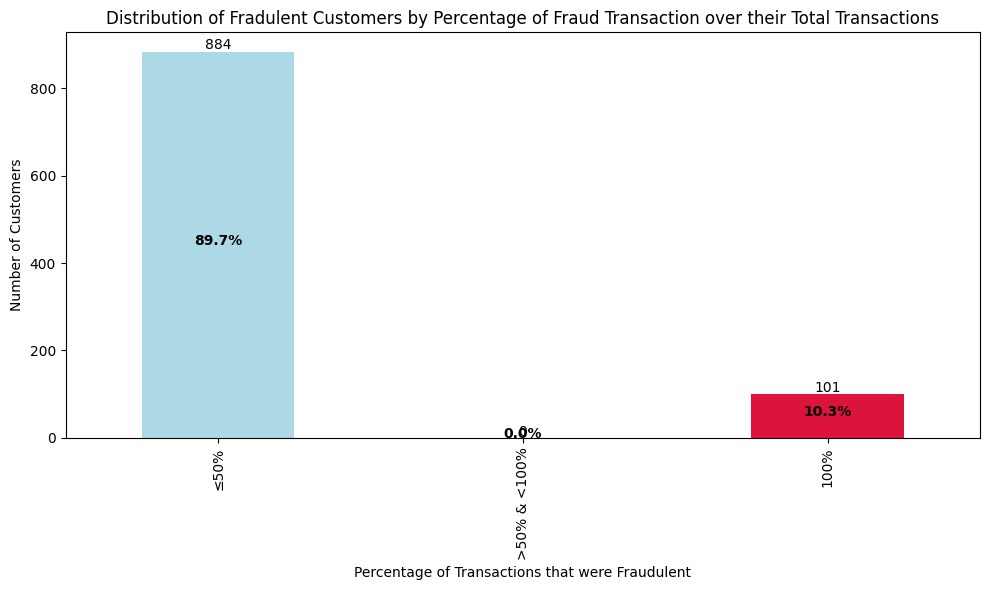

Total customers with at least one fraudulent transaction: 985
Customers with ≤50% fraudulent transactions: 884 (89.7%)
Customers with >50% & <100% fraudulent transactions: 0 (0.0%)
Customers with 100% fraudulent transactions: 101 (10.3%)


In [55]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = bin_counts.plot(kind='bar', color=['lightblue', 'orange', 'crimson'])
plt.title('Distribution of Fradulent Customers by Percentage of Fraud Transaction over their Total Transactions')
plt.xlabel('Percentage of Transactions that were Fraudulent')
plt.ylabel('Number of Customers')

# Add count labels on top of each bar
for i, count in enumerate(bin_counts):
    plt.text(i, count + 5, str(count), ha='center')

# Add a percentage label inside each bar
total_customers = bin_counts.sum()
for i, count in enumerate(bin_counts):
    percentage = (count / total_customers) * 100
    plt.text(i, count/2, f"{percentage:.1f}%", ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total customers with at least one fraudulent transaction: {total_customers}")
for label, count in bin_counts.items():
    print(f"Customers with {label} fraudulent transactions: {count} ({count/total_customers*100:.1f}%)")

In [46]:
# Finding their first transaction 
customer_first_trans = df.sort_values(['ssn', 'trans_date', 'trans_time']).groupby('ssn').head(1)

# Count of fraudulent first transactions 
fraud_first_trans_count = customer_first_trans['is_fraud'].sum()

print(f"Number of customers whose first transaction was fraudulent: {fraud_first_trans_count}")
print(f"Percentage of customers whose first transaction was fraudulent: {(fraud_first_trans_count/total_customers_ssn) *100}")

Number of customers whose first transaction was fraudulent: 102
Percentage of customers whose first transaction was fraudulent: 10.230692076228685


In [47]:
fraud_count_mc.groupby('ssn')['ssn'].count() 

ssn
59318309     1
69452671     1
96658934     1
136674961    1
162088321    1
193015279    1
206427252    1
242807389    1
297220579    1
437446587    1
452579812    1
504142358    1
546989371    1
552207135    1
581884763    1
589058010    1
601895938    1
603456914    1
627469417    1
649608105    1
755111150    1
766623506    1
808050763    1
832275040    1
855200599    1
860084836    1
877448505    1
Name: ssn, dtype: int64

In [48]:
fraud_count_by_consumers = fraud_filter('ssn').sort_values(by='fraud_count', ascending=False)
fraud_count_by_consumers.head(10)

,ssn,fraud_count
719,648073243,19
744,672906422,18
454,428323432,17
846,766623506,16
536,498557900,16
341,311934315,16
890,805105003,16
581,535663820,16
614,562518571,16
284,251747057,16


In [49]:
least_fraud_c = fraud_count_by_consumers.sort_values(by='fraud_count', ascending=True)
least_fraud_c.head(10)

,ssn,fraud_count
548,505026947,2
553,507888724,2
654,590868736,2
638,581080162,2
151,125638352,2
490,465986615,2
215,182220390,2
567,525567036,2
637,580380878,2
703,630564499,3


### Fraudulent transactions by value

**Fraud involves larger sums**

Transaction between $500 to $1000 shows the highest proportion of fraudulent transaction and as such it could be used to create a new feature using transaction amount bins

In [56]:
labels = ['0-100', '100-500', '500-1000', '1000-5000', '>5000']
bins = [0, 100, 500, 1000, 5000, float('inf')]

# Create a new column with the range
fraud_count['amt_range'] = pd.cut(fraud_count['amt'], bins=bins, labels=labels, right=False) # note to myself: look into this concept
fraud_count.groupby('amt_range')['is_fraud'].mean()

KeyError: 'amt'